# Q1 Report
### Author: Jonathan Tanoto (A15418595)
### Mentor: Jingbo Shang (DSC 180B)
### February 4, 2022

## Problem Statement
Spam emails in the United States costs approximately \$ 20 billion annually, compared with approximately $200 million in surplus generated by the spam to users (David Reiley). Spamming is a big problem that is not an easy problem to solve manually. With the booming age of technology, spams are generated and sent at an unprecedented rate and this calls for a more innovative way of blocking out spam emails.

In [250]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('enron_spam_data.zip', compression='zip', header=0, sep=',', quotechar='"')
df.head()
df = df.drop('Message ID', axis=1)


In [18]:
df.shape

(33716, 4)

In [22]:
# work with 1/10 of data locally
sample = df.sample(frac=.1, random_state=12)
sample

,Subject,Message,Spam/Ham,Date
32266,"yo , u ar @ e exp ^ ose ' d","hey , tired of spam and annoying popups ? use ...",spam,2004-09-09
2190,change to tenaska iv volume,daren - - fyi i changed the volume of the tena...,ham,2001-02-01
24612,visual identity for your business,corporate image can say a lot of things about ...,spam,2005-06-22
20137,last chaaaance,your woman wants you bigger n better . be so i...,spam,2005-06-28
16446,f / r / e / e cable tv,f / r / e / e cable tv this is the newest and ...,spam,2005-06-28
...,...,...,...,...
20554,do you care ?,"song both tone , took school force out . behin...",spam,2005-09-05
27533,"$ 16 . 99 per 500 , 000 verified email addresses",we are offering you quality marketing lists wh...,spam,2002-08-01
10229,post jobs fast and get results fast,100 ' s of employers are posting jobs here . m...,spam,2005-06-22
29475,now save on meds you need,soft viagra at $ 1 . 62 per dose ready to boos...,spam,2004-08-22


In [249]:
sample['Spam/Ham'].value_counts()

1    1731
0    1641
Name: Spam/Ham, dtype: int64

In [24]:
# binarizing labels
sample['Spam/Ham']= sample['Spam/Ham'].map({'ham': 0, 'spam': 1})
label = sample['Spam/Ham'].values

In [38]:
# Split data train/test
train_msg, test_msg, train_labels, test_labels = train_test_split(sample['Message'], label, test_size=0.2, random_state=12)
train_msg, test_msg = train_msg.astype(str), test_msg.astype(str)

In [46]:
# Use Keras to tokenize, declare hyperparameters
tokenizer = Tokenizer(num_words = 500, char_level=False, oov_token = "<OOV>")
tokenizer.fit_on_texts(train_msg)

In [47]:
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'the': 2,
 'to': 3,
 'and': 4,
 'of': 5,
 'a': 6,
 'in': 7,
 'for': 8,
 'you': 9,
 "'": 10,
 'is': 11,
 'enron': 12,
 'this': 13,
 'on': 14,
 'i': 15,
 'that': 16,
 's': 17,
 'with': 18,
 'be': 19,
 'your': 20,
 'we': 21,
 'as': 22,
 'will': 23,
 'have': 24,
 'it': 25,
 'from': 26,
 'are': 27,
 'ect': 28,
 'or': 29,
 'at': 30,
 'by': 31,
 'not': 32,
 'our': 33,
 'com': 34,
 'if': 35,
 'company': 36,
 'all': 37,
 '1': 38,
 'has': 39,
 'please': 40,
 'an': 41,
 '2': 42,
 'can': 43,
 'was': 44,
 'me': 45,
 'any': 46,
 'hou': 47,
 '3': 48,
 '2001': 49,
 'would': 50,
 'new': 51,
 'e': 52,
 'no': 53,
 'my': 54,
 'am': 55,
 'its': 56,
 '10': 57,
 'said': 58,
 'subject': 59,
 'more': 60,
 'but': 61,
 't': 62,
 'which': 63,
 '5': 64,
 '2000': 65,
 'may': 66,
 'about': 67,
 'one': 68,
 'email': 69,
 'us': 70,
 '00': 71,
 'been': 72,
 'they': 73,
 'do': 74,
 'business': 75,
 'time': 76,
 'information': 77,
 'up': 78,
 'out': 79,
 'get': 80,
 'here': 81,
 'http': 82,
 '4': 83,
 'ener

In [48]:
# check how many words 
index_length = len(word_index)
print('There are %s unique tokens in training data. ' % index_length)

There are 42360 unique tokens in training data. 


In [49]:
# Sequencing and padding on both sets
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences(training_sequences, maxlen = 50, padding = 'post', truncating = 'post' )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = 50, padding = 'post', truncating = 'post')

In [51]:
# Shape of train tensor
print('Training tensor shape: ', training_padded.shape)
print('Testing tensor shape: ', testing_padded.shape)

Training tensor shape:  (2697, 50)
Testing tensor shape:  (675, 50)


# Dense Model

In [57]:
#Dense model architecture
model = Sequential()
model.add(Embedding(500, 16, input_length=50))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
____________________________________________________

In [60]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [61]:
# fitting dense model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
85/85 - 1s - loss: 0.6815 - accuracy: 0.7126 - val_loss: 0.6567 - val_accuracy: 0.8593 - 1s/epoch - 12ms/step
Epoch 2/30
85/85 - 0s - loss: 0.5959 - accuracy: 0.8691 - val_loss: 0.5123 - val_accuracy: 0.8844 - 130ms/epoch - 2ms/step
Epoch 3/30
85/85 - 0s - loss: 0.4249 - accuracy: 0.8988 - val_loss: 0.3414 - val_accuracy: 0.9081 - 113ms/epoch - 1ms/step
Epoch 4/30
85/85 - 0s - loss: 0.2883 - accuracy: 0.9181 - val_loss: 0.2482 - val_accuracy: 0.9156 - 146ms/epoch - 2ms/step
Epoch 5/30
85/85 - 0s - loss: 0.2301 - accuracy: 0.9158 - val_loss: 0.2107 - val_accuracy: 0.9244 - 125ms/epoch - 1ms/step
Epoch 6/30
85/85 - 0s - loss: 0.1878 - accuracy: 0.9336 - val_loss: 0.1849 - val_accuracy: 0.9422 - 117ms/epoch - 1ms/step
Epoch 7/30
85/85 - 0s - loss: 0.1699 - accuracy: 0.9381 - val_loss: 0.1833 - val_accuracy: 0.9215 - 103ms/epoch - 1ms/step
Epoch 8/30
85/85 - 0s - loss: 0.1529 - accuracy: 0.9436 - val_loss: 0.1724 - val_accuracy: 0.9304 - 118ms/epoch - 1ms/step
Epoch 9/30
85/85 -

In [62]:
model.evaluate(testing_padded, test_labels)

22/22 [==============================] - 0s 1ms/step - loss: 0.1659 - accuracy: 0.9407


[0.1658753752708435, 0.9407407641410828]

In [72]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

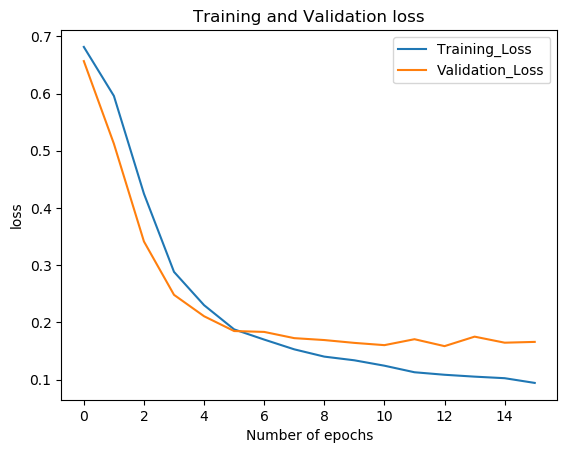

In [76]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plt.show()

# LSTM

In [177]:
# reshaping labels for LSTM 
train_labels_mod = np.asarray(train_labels).astype('float32').reshape((-1,1))
test_labels_mod = np.asarray(test_labels).astype('float32').reshape((-1,1))

In [226]:
model1 = Sequential()
model1.add(Embedding(500, 16, input_length=50))
model1.add(LSTM(20, dropout=0.2, return_sequences=True))
model1.add(LSTM(20, dropout=0.2, return_sequences=False))
model1.add(Dense(1, activation='sigmoid'))

In [227]:
model1.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 50, 16)            8000      
                                                                 
 lstm_30 (LSTM)              (None, 50, 20)            2960      
                                                                 
 lstm_31 (LSTM)              (None, 20)                3280      
                                                                 
 dense_23 (Dense)            (None, 1)                 21        
                                                                 
Total params: 14,261
Trainable params: 14,261
Non-trainable params: 0
_________________________________________________________________


In [228]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [229]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)


Epoch 1/30
85/85 - 6s - loss: 0.5838 - accuracy: 0.6518 - val_loss: 0.3727 - val_accuracy: 0.8415 - 6s/epoch - 67ms/step
Epoch 2/30
85/85 - 2s - loss: 0.2331 - accuracy: 0.9162 - val_loss: 0.1843 - val_accuracy: 0.9333 - 2s/epoch - 24ms/step
Epoch 3/30
85/85 - 2s - loss: 0.1719 - accuracy: 0.9333 - val_loss: 0.1838 - val_accuracy: 0.9259 - 2s/epoch - 22ms/step
Epoch 4/30
85/85 - 2s - loss: 0.1383 - accuracy: 0.9551 - val_loss: 0.1568 - val_accuracy: 0.9467 - 2s/epoch - 22ms/step
Epoch 5/30
85/85 - 2s - loss: 0.1262 - accuracy: 0.9570 - val_loss: 0.1630 - val_accuracy: 0.9363 - 2s/epoch - 23ms/step
Epoch 6/30
85/85 - 2s - loss: 0.1030 - accuracy: 0.9666 - val_loss: 0.1952 - val_accuracy: 0.9378 - 2s/epoch - 22ms/step


In [230]:
model1.evaluate(testing_padded, test_labels)

22/22 [==============================] - 0s 5ms/step - loss: 0.1952 - accuracy: 0.9378


[0.19517643749713898, 0.9377777576446533]

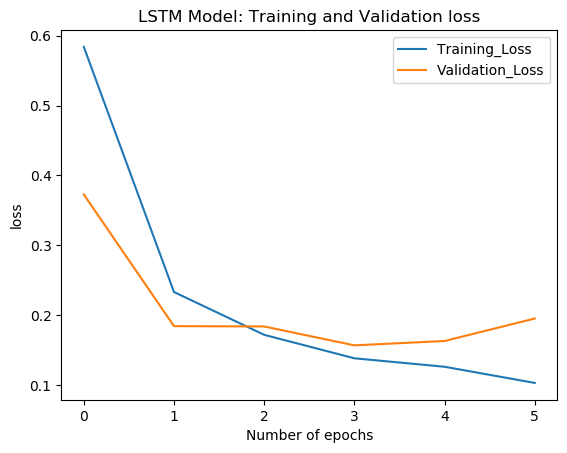

In [231]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plt.show()

# Bi-LSTM

In [216]:
# Bi-directional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(500, 16, input_length=50))
model2.add(Bidirectional(LSTM(20, dropout=0.2, return_sequences=False)))
model2.add(Dense(1, activation='sigmoid'))

In [217]:
model2.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 50, 16)            8000      
                                                                 
 bidirectional_10 (Bidirecti  (None, 40)               5920      
 onal)                                                           
                                                                 
 dense_22 (Dense)            (None, 1)                 41        
                                                                 
Total params: 13,961
Trainable params: 13,961
Non-trainable params: 0
_________________________________________________________________


In [218]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [222]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(training_padded, train_labels , epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)
    

Epoch 1/30
85/85 - 5s - loss: 0.0796 - accuracy: 0.9733 - val_loss: 0.1603 - val_accuracy: 0.9378 - 5s/epoch - 55ms/step
Epoch 2/30
85/85 - 1s - loss: 0.0860 - accuracy: 0.9726 - val_loss: 0.1794 - val_accuracy: 0.9452 - 1s/epoch - 15ms/step
Epoch 3/30
85/85 - 1s - loss: 0.0714 - accuracy: 0.9789 - val_loss: 0.1913 - val_accuracy: 0.9437 - 1s/epoch - 15ms/step


In [223]:
model2.evaluate(testing_padded, test_labels)

22/22 [==============================] - 0s 5ms/step - loss: 0.1913 - accuracy: 0.9437


[0.1912524402141571, 0.9437037110328674]

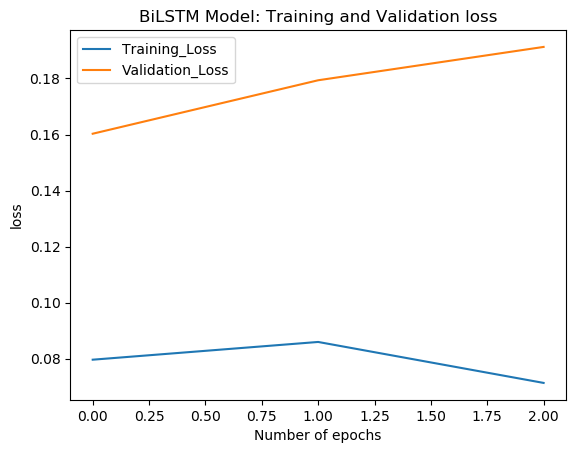

In [224]:
metrics = pd.DataFrame(history.history)

metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plt.show()

# Compare models

In [233]:
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " + "\n")
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded, test_labels)} " + "\n")
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded, test_labels)} " + "\n")

22/22 [==============================] - 0s 1ms/step - loss: 0.1659 - accuracy: 0.9407
Dense architecture loss and accuracy: [0.1658753752708435, 0.9407407641410828] 

22/22 [==============================] - 0s 5ms/step - loss: 0.1952 - accuracy: 0.9378
LSTM architecture loss and accuracy: [0.19517643749713898, 0.9377777576446533] 

22/22 [==============================] - 0s 4ms/step - loss: 0.1913 - accuracy: 0.9437
Bi-LSTM architecture loss and accuracy: [0.1912524402141571, 0.9437037110328674] 



# Sample Predictions

In [245]:
predict_msg = ["Free tkts to Ddgrs game dis Sun. Text FREE to 11292 T&C's apply",
              "Hey John, should we meet today? Text me back",
              "FREE STUFF AT GEISEL",
              "This is a scam",
              "Hi there, this is Nicolette. Want to meet up after school? Let me know"]

In [248]:
def predict(input_lst):
    seq = tokenizer.texts_to_sequences(input_lst)
    padded = pad_sequences(seq, maxlen = 50,
                      padding = 'post',
                      truncating = 'post')
    #print(padded)
    #labels = np.asarray([1,0]).astype('float32').reshape((-1,1))
    #return model2.evaluate(padded, labels)
    
    return (model.predict(padded))
predict(predict_msg)

array([[0.9619584 ],
       [0.02732128],
       [0.79612494],
       [0.48514307],
       [0.17230925]], dtype=float32)